# case 2

lid driven cavity

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.scipy.sparse.linalg import cg
from jax.scipy.ndimage import map_coordinates
from typing import NamedTuple
import matplotlib.pyplot as plt

In [2]:
class FluidConfig:
    N_x = 128            #  (N x N)
    N_y = 128
    Lx = 1.0       # spacial scale. in previous code, spacial scale is not considered. that is, one cell with length 1
    Ly = 1.0
    dx = Lx / N_x
    dy = Ly / N_y

    DT = 0.01 # 0.001 # 0.05          # time step
    VISCOSITY = 0.001 # Diffusion strength
    DIFFUSION_ITER = 20 # CG step for diffusion
    PRESSURE_ITER = 50  # CG step for pressure

    LID_V = 1.0

class FluidState(NamedTuple):
    u: jnp.ndarray     
    v: jnp.ndarray

In [3]:
def laplacian(f, dx,dy, mode):
    '''
    mode have to be 'edge' or 'constant'
    '''
    f_extended = jnp.pad(f, ((1, 1), (1, 1)), mode=mode)
    
    left  = jnp.roll(f_extended, 1, axis=1)
    right = jnp.roll(f_extended, -1, axis=1)
    down  = jnp.roll(f_extended, 1, axis=0)
    up    = jnp.roll(f_extended, -1, axis=0)
    la_x = (left - 2.0*f_extended + right)/(dx*dx)
    la_y = (up - 2.0*f_extended + down) / (dy*dy)
    la = la_x+la_y
    return la[1:-1, 1:-1]

def divergence(u, v, dx, dy):
    u_extended = jnp.pad(u, ((1, 1), (1, 1)), mode='constant')
    v_extended = jnp.pad(v, ((1, 1), (1, 1)), mode='constant')
    
    du_dx = (jnp.roll(u_extended, -1, axis=1) - jnp.roll(u_extended, 1, axis=1)) / (2.0 * dx)
    dv_dy = (jnp.roll(v_extended, -1, axis=0) - jnp.roll(v_extended, 1, axis=0)) / (2.0 * dy)
    return (du_dx + dv_dy)[1:-1, 1:-1]

def gradient(p, dx, dy):
    p_extended = jnp.pad(p, ((1, 1), (1, 1)), mode='edge')
    du_dx = (jnp.roll(p_extended, -1, axis=1) - jnp.roll(p_extended, 1, axis=1)) / (2.0 * dx)
    dv_dy = (jnp.roll(p_extended, -1, axis=0) - jnp.roll(p_extended, 1, axis=0)) / (2.0 * dy)
    return du_dx[1:-1, 1:-1], dv_dy[1:-1, 1:-1]

In [4]:
def advect(f,u,v,dt,dx,dy):
    mesh_y, mesh_x = jnp.meshgrid(jnp.arange(FluidConfig.N_y), jnp.arange(FluidConfig.N_x), indexing='ij')
    mesh_x_new = mesh_x - (u * dt) / dx
    mesh_y_new = mesh_y - (v * dt) / dy
    coords = jnp.stack([mesh_y_new, mesh_x_new], axis=0)
    return map_coordinates(f, coords, order=1, mode='constant', cval=0.0)

def diffuse(f,viscosity,dt, n_iter, dx, dy):
    if viscosity == 0:
        return f
    alpha = viscosity * dt

    def linear_op(x):
        return x - alpha * laplacian(x, dx, dy, mode='constant')

    f_new, _ = cg(linear_op, f, maxiter=n_iter)
    return f_new

def pressure(div, n_iter, dx, dy):
    def laplacian_op(p):
        return laplacian(p, dx, dy, mode='edge')
    #p, _ = cg(laplacian_op, div, maxiter=n_iter)
    p_init = jnp.zeros_like(div)
    p, _ = cg(laplacian_op, div, x0=p_init, maxiter=n_iter)
    return p

def project(u, v, n_iter, dx, dy):
    div = divergence(u, v, dx, dy)
    p = pressure(div, n_iter, dx, dy)
    grad_p_x, grad_p_y = gradient(p, dx, dy)
    return u - grad_p_x, v - grad_p_y

def apply_kolmogorov_forcing(u, v, dt, scale, k):
    y = jnp.linspace(0.0, FluidConfig.Ly, FluidConfig.N_y, endpoint=False)
    forcing_grid = jnp.sin(k * y)[:, None]
    
    u_new = u + dt * scale * forcing_grid
    return u_new, v

In [5]:
def apply_bc(u, v):
    # Bottom 
    u = u.at[0, :].set(0.0)
    v = v.at[0, :].set(0.0)
    
    # Top 
    u = u.at[-1, :].set(FluidConfig.LID_V) 
    v = v.at[-1, :].set(0.0)
    
    # Left (x=0)
    u = u.at[:, 0].set(0.0)
    v = v.at[:, 0].set(0.0)
    
    # Right (x=Lx)
    u = u.at[:, -1].set(0.0)
    v = v.at[:, -1].set(0.0)
    
    return u, v

In [6]:
@jax.jit
def step_fn(state: FluidState) -> FluidState:
    u, v = state.u, state.v
   
    # self-advection
    u_adv = advect(u, u, v, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy)
    v_adv = advect(v, u, v, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy)
    
    # BC
    u_adv, v_adv = apply_bc(u_adv, v_adv)
    
    # Diffuse
    u_diff = diffuse(u_adv, FluidConfig.VISCOSITY, FluidConfig.DT, FluidConfig.DIFFUSION_ITER, FluidConfig.dx, FluidConfig.dy)
    v_diff = diffuse(v_adv, FluidConfig.VISCOSITY, FluidConfig.DT, FluidConfig.DIFFUSION_ITER, FluidConfig.dx, FluidConfig.dy)
    
    # BC
    u_diff, v_diff = apply_bc(u_diff, v_diff)
    
    # projection
    u_final, v_final = project(u_diff, v_diff, FluidConfig.PRESSURE_ITER, FluidConfig.dx, FluidConfig.dy)
    
    # BC
    u_final, v_final = apply_bc(u_final, v_final)
    
    return FluidState(u_final, v_final)

In [7]:
def init_velocity():
    u = jnp.zeros((FluidConfig.N_y, FluidConfig.N_x))
    v = jnp.zeros((FluidConfig.N_y, FluidConfig.N_x))
    return FluidState(u, v)

In [8]:
# generate data

In [9]:
state = init_velocity()
_ = step_fn(state)

n_frames = 12
steps_per_frame = 100

u_list = []
v_list = []

for i in range(n_frames):
    for _ in range(steps_per_frame):
        state = step_fn(state)
        
    
    u = jax.device_get(state.u)
    v = jax.device_get(state.v)
    u_list.append(u)
    v_list.append(v)

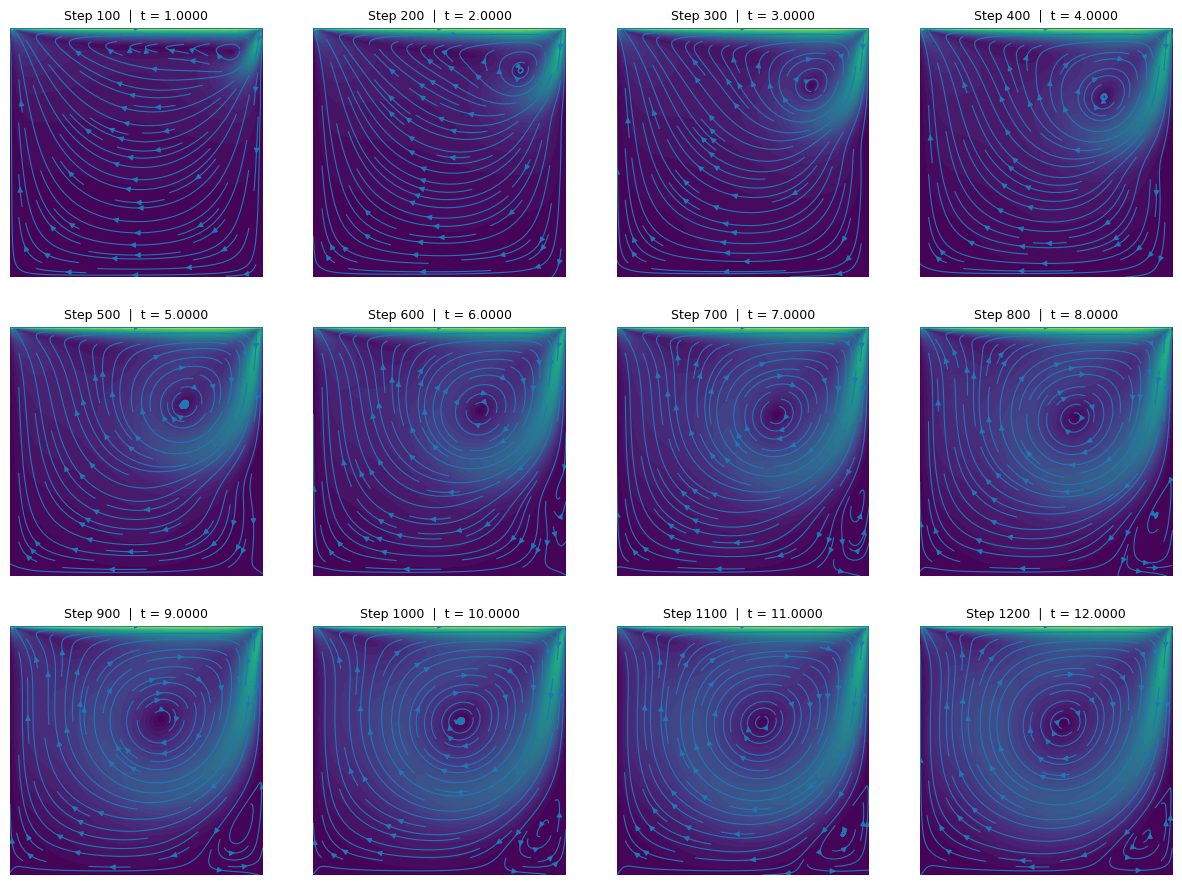

In [10]:
x = np.arange(FluidConfig.N_x) * FluidConfig.dx
y = np.arange(FluidConfig.N_y) * FluidConfig.dy
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(3, 4, figsize=(15, 11))

for i, ax in enumerate(axes.flat):
    u = u_list[i]
    v = v_list[i]

    speed = np.sqrt(u*u + v*v)
    ax.contourf(X, Y, speed, levels=50, cmap='viridis')

    ax.streamplot(
        X, Y, u, v,
        density=1.0,
        linewidth=0.8,
        arrowsize=0.8
    )
    ax.set_aspect('auto')

    t = (i+1) * steps_per_frame * FluidConfig.DT
    ax.set_title(f"Step {(i+1) * steps_per_frame}  |  t = {t:.4f}", fontsize=9)
    
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.autoscale(False)
    ax.set_axis_off()
    

fig.set_constrained_layout_pads(
    wspace=0.1,
    hspace=0.1
)

plt.savefig('case_2_lid_driven.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
u.shape

(128, 128)

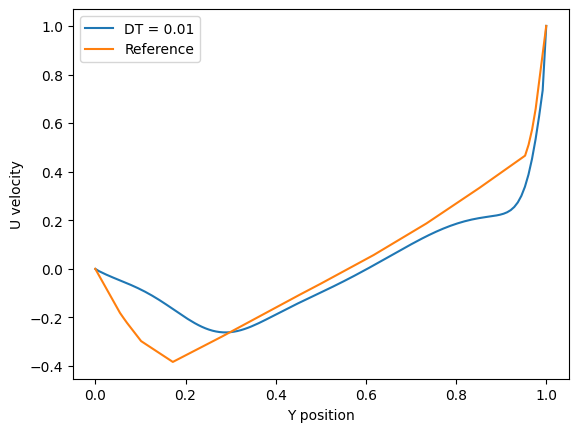

In [47]:
plt.plot(jnp.arange(128)/127, u_list[-1][:,63], label='DT = 0.01')
plt.plot([1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000], 
         [1.0, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702, -0.06080, -0.10648, -0.27805,
                            -0.38289, -0.29730, -0.22220, -0.20196, -0.18109, 0.00000],label='Reference')

plt.xlabel('Y position')
plt.ylabel('U velocity')
plt.legend()

In [16]:
FluidState.DT = 0.001
state = init_velocity()
_ = step_fn(state)

n_frames = 12
steps_per_frame = 1000

for i in range(n_frames):
    for _ in range(steps_per_frame):
        state = step_fn(state)
        
u_dt_0p001 = jax.device_get(state.u)

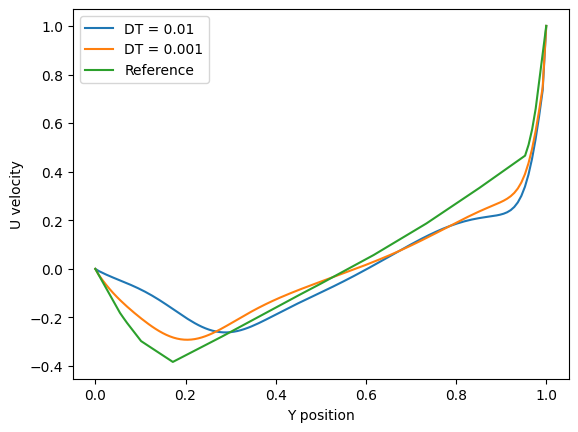

In [49]:
plt.plot(jnp.arange(128)/127, u_list[-1][:,63],label='DT = 0.01')
plt.plot(jnp.arange(128)/127, u_dt_0p001[:,63],label='DT = 0.001')
plt.plot([1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000], 
         [1.0, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702, -0.06080, -0.10648, -0.27805,
                            -0.38289, -0.29730, -0.22220, -0.20196, -0.18109, 0.00000],label='Reference')
plt.xlabel('Y position')
plt.ylabel('U velocity')
plt.savefig('u_profile.png',  dpi=300, bbox_inches='tight')
plt.legend()